In [1]:
from openTSNE import TSNE, TSNEEmbedding
from openTSNE import affinity
from openTSNE import initialization
from openTSNE.callbacks import ErrorLogger

from examples import utils

import numpy as np
import pandas as pd
import scipy.sparse as sp

import matplotlib.pyplot as plt

In [2]:
import anndata
import scanpy as sc

/home/ppolicar/local/miniconda3/envs/tsne/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [3]:
adata = anndata.read_h5ad(path.join("..", "data", "hrvatin_2018.h5ad"))
sc.pp.filter_genes(adata, min_counts=1)
adata

AnnData object with n_obs × n_vars = 48266 × 20394 
    obs: 'labels', 'batch_id', 'paper_cell_type', 'paper_cell_subtype'
    var: 'n_counts'
    uns: 'name', 'organism', 'tissue', 'year'

In [4]:
adata.obs["labels"].value_counts()

neuron of cerebral cortex         14150
microglial cell                   10158
oligodendrocyte                    8630
astrocyte                          7039
endothelial cell                   3450
oligodendrocyte precursor cell     1826
CNS interneuron                     936
pericyte cell                       782
smooth muscle cell                  621
macrophage                          537
hippocampal neuron                  137
Name: labels, dtype: int64

Chosen offset: 0.34
Chosen offset: 1.21


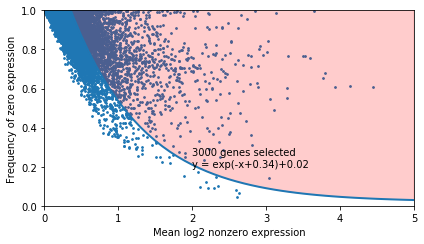

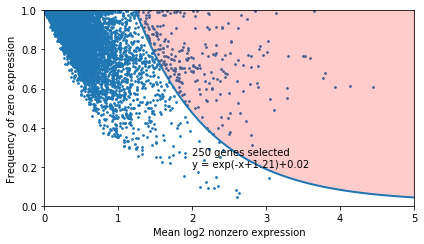

In [9]:
gene_mask_3000 = utils.select_genes(adata.X, n=3000, threshold=0)
gene_mask_250 = utils.select_genes(adata.X, n=250, threshold=0)

In [10]:
adata_norm = adata.copy()
sc.pp.normalize_per_cell(adata_norm, counts_per_cell_after=1_000_000)
sc.pp.log1p(adata_norm)

In [11]:
adata_norm.X = adata_norm.X.toarray()
adata_norm.X -= adata_norm.X.mean(axis=0)
adata_norm.X /= adata_norm.X.std(axis=0)

In [12]:
adata_250 = adata_norm[:, gene_mask_250].copy()
adata_3000 = adata_norm[:, gene_mask_3000].copy()
adata_full = adata_norm

In [13]:
%%time
for adata_ in [adata_250, adata_3000, adata_full]:
    print("Computing PCA for %d genes" % adata_.shape[1])
    U, S, V = np.linalg.svd(adata_.X, full_matrices=False)
    U[:, np.sum(V, axis=1) < 0] *= -1
    adata_.obsm["pca"] = np.dot(U, np.diag(S))
    adata_.obsm["pca"] = adata_.obsm["pca"][:, np.argsort(S)[::-1]][:, :50]

Computing PCA for 250 genes
Computing PCA for 3000 genes
Computing PCA for 20394 genes
CPU times: user 9h 12min 47s, sys: 8min 54s, total: 9h 21min 41s
Wall time: 16min 29s


## Run t-SNE

In [14]:
%%time
for adata_ in [adata_250, adata_3000, adata_full]:
    print("Computing t-SNE for %d genes" % adata_.shape[1])
    affinities = affinity.Multiscale(
        adata_.obsm["pca"],
        perplexities=[50, 500],
        metric="cosine",
        n_jobs=8,
        random_state=3,
    )
    init = initialization.pca(adata_.obsm["pca"], random_state=42)
    embedding = TSNEEmbedding(
        init,
        affinities,
        negative_gradient_method="fft",
        n_jobs=8,
    )
    embedding.optimize(n_iter=250, exaggeration=12, momentum=0.5, inplace=True)
    embedding.optimize(n_iter=750, exaggeration=1, momentum=0.8, inplace=True)
    
    adata_.obsm["tsne"] = embedding

Computing t-SNE for 250 genes
Computing t-SNE for 3000 genes
Computing t-SNE for 20394 genes
CPU times: user 7h 8min 23s, sys: 7min 6s, total: 7h 15min 29s
Wall time: 22min 54s


In [15]:
adata_250.write_h5ad("hrvatin_embedding_tsne_250_genes.h5ad")
adata_3000.write_h5ad("hrvatin_embedding_tsne_3000_genes.h5ad")
adata_full.write_h5ad("hrvatin_embedding_tsne_all_genes.h5ad")

... storing 'labels' as categorical
... storing 'labels' as categorical
... storing 'labels' as categorical


In [16]:
adata_250 = anndata.read_h5ad("hrvatin_embedding_tsne_250_genes.h5ad")
adata_3000 = anndata.read_h5ad("hrvatin_embedding_tsne_3000_genes.h5ad")
adata_full = anndata.read_h5ad("hrvatin_embedding_tsne_all_genes.h5ad")

In [17]:
legend_kwargs = dict(loc="center", bbox_to_anchor=(0.5, -0.05), ncol=len(np.unique(adata.obs["labels"])))

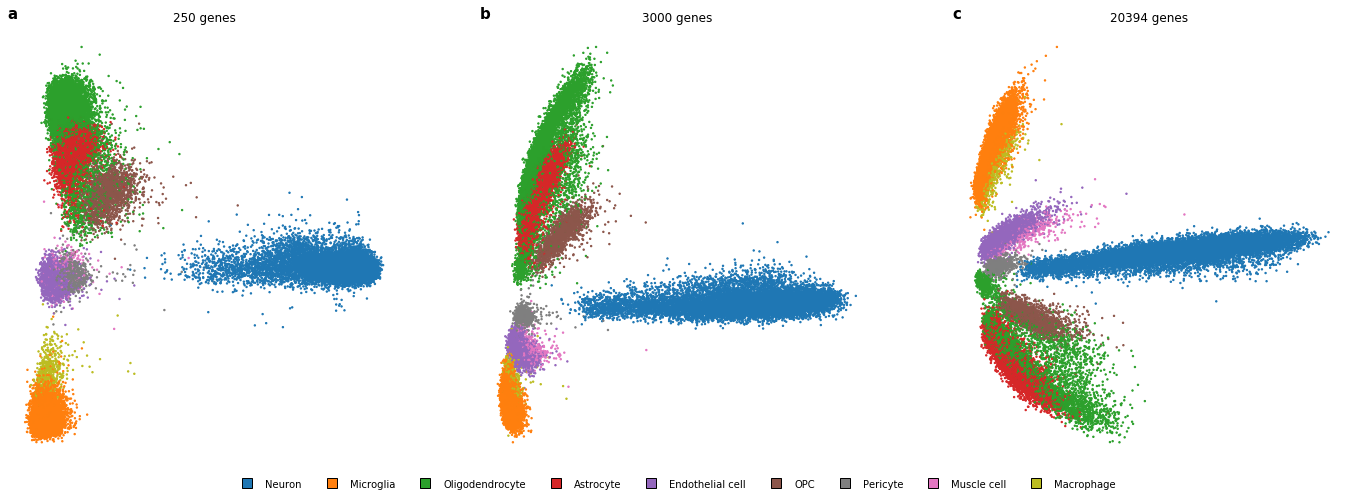

In [18]:
fig, ax = plt.subplots(ncols=3, figsize=(24, 8))

utils.plot(adata_250.obsm["pca"], adata.obs["labels"],  s=2, colors=colors, draw_legend=False, ax=ax[0], alpha=1, title="250 genes", label_order=list(colors.keys()))
utils.plot(adata_3000.obsm["pca"], adata.obs["labels"], s=2, colors=colors, draw_legend=True, ax=ax[1], alpha=1, title="3000 genes", label_order=list(colors.keys()),
          legend_kwargs=legend_kwargs)
utils.plot(adata_full.obsm["pca"], adata.obs["labels"], s=2, colors=colors, draw_legend=False, ax=ax[2], alpha=1, title="20394 genes", label_order=list(colors.keys()))

plt.text(0, 1.02, "a", transform=ax[0].transAxes, fontsize=15, fontweight="bold")
plt.text(0, 1.02, "b", transform=ax[1].transAxes, fontsize=15, fontweight="bold")
plt.text(0, 1.02, "c", transform=ax[2].transAxes, fontsize=15, fontweight="bold")

plt.savefig("hrvatin_embedding_pca_genes.png", dpi=100, bbox_inches="tight", transparent=True)
plt.savefig("hrvatin_embedding_pca_genes.pdf", dpi=600, bbox_inches="tight", transparent=True)

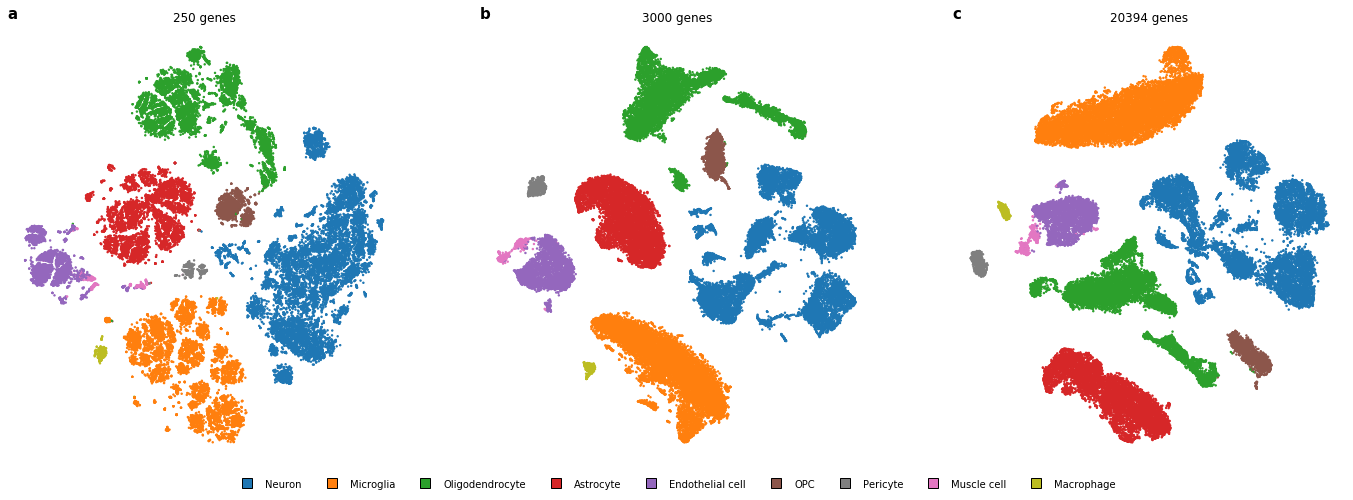

In [19]:
fig, ax = plt.subplots(ncols=3, figsize=(24, 8))

utils.plot(adata_250.obsm["tsne"],  adata.obs["labels"], s=2, colors=colors, draw_legend=False, ax=ax[0], alpha=1, title="250 genes", label_order=list(colors.keys()))
utils.plot(adata_3000.obsm["tsne"], adata.obs["labels"], s=2, colors=colors, draw_legend=True, ax=ax[1], alpha=1, title="3000 genes", label_order=list(colors.keys()),
           legend_kwargs=legend_kwargs)
utils.plot(adata_full.obsm["tsne"], adata.obs["labels"], s=2, colors=colors, draw_legend=False, ax=ax[2], alpha=1, title="20394 genes", label_order=list(colors.keys()))

plt.text(0, 1.02, "a", transform=ax[0].transAxes, fontsize=15, fontweight="bold")
plt.text(0, 1.02, "b", transform=ax[1].transAxes, fontsize=15, fontweight="bold")
plt.text(0, 1.02, "c", transform=ax[2].transAxes, fontsize=15, fontweight="bold")

plt.savefig("hrvatin_embedding_tsne_genes.png", dpi=100, bbox_inches="tight", transparent=True)
plt.savefig("hrvatin_embedding_tsne_genes.pdf", dpi=600, bbox_inches="tight", transparent=True)

## Transform

In [20]:
new = anndata.read_h5ad(path.join("..", "data", "chen_2017.h5ad"))

In [21]:
new.obs["labels"].value_counts()

oligodendrocyte                   3541
unknown                           2531
oligodendrocyte precursor cell    1792
GABAergic neuron                  1392
epithelial cell                   1197
astrocyte                         1148
glutamatergic neuron               906
microglial cell                    724
tanycyte                           609
ependymal cell                     413
macrophage                         167
histaminergic neuron                17
Name: labels, dtype: int64

In [23]:
cell_mask = new.obs["labels"].isin(adata.obs["labels"])
cell_mask.sum()

9687

In [24]:
new = new[cell_mask].copy()

In [25]:
shared_genes = adata.var_names[adata.var_names.isin(new.var_names)]
shared_genes

Index(['0610007P14RIK', '0610009B22RIK', '0610009L18RIK', '0610009O20RIK',
       '0610010F05RIK', '0610010K14RIK', '0610011F06RIK', '0610012G03RIK',
       '0610030E20RIK', '0610031O16RIK',
       ...
       'ZUFSP', 'ZW10', 'ZWILCH', 'ZWINT', 'ZXDB', 'ZXDC', 'ZYG11B', 'ZYX',
       'ZZEF1', 'ZZZ3'],
      dtype='object', name='index', length=16628)

In [26]:
adata = adata[:, adata.var_names.isin(shared_genes)]
new = new[:, new.var_names.isin(shared_genes)]

In [27]:
adata = adata[:, adata.var_names.argsort()].copy()
new = new[:, new.var_names.argsort()].copy()
assert all(adata.var_names == new.var_names)

Chosen offset: 1.19
Chosen offset: 0.58
Chosen offset: 0.24


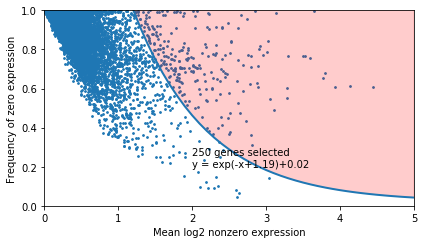

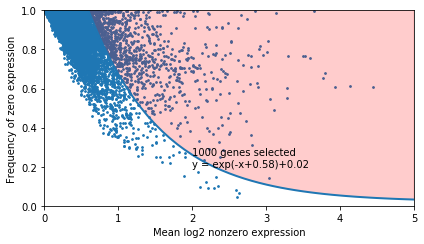

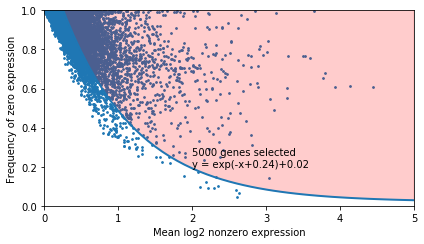

In [28]:
gene_mask_250 = utils.select_genes(adata.X, n=250, threshold=0)
gene_mask_1000 = utils.select_genes(adata.X, n=1000, threshold=0)
gene_mask_5000 = utils.select_genes(adata.X, n=5000, threshold=0)

In [29]:
adata_250 = adata[:, gene_mask_250].copy()
adata_1000 = adata[:, gene_mask_1000].copy()
adata_5000 = adata[:, gene_mask_5000].copy()

new_250 = new[:, gene_mask_250].copy()
new_1000 = new[:, gene_mask_1000].copy()
new_5000 = new[:, gene_mask_5000].copy()

In [40]:
%%time
affinity_obs = {}
for adata_, new_ in [(adata_250, new_250), (adata_1000, new_1000), (adata_5000, new_5000)]:
    print("Running transform for %d genes" % adata_.shape[1])
    affinities = affinity.PerplexityBasedNN(
        adata_.X.toarray() if sp.issparse(adata_.X) else adata_.X,
        perplexity=30,
        metric="cosine",
        n_jobs=8,
        random_state=3,
    )
    affinity_obs[adata_.shape[1]] = affinities
    embedding = TSNEEmbedding(
        adata_3000.obsm["tsne"],
        affinities,
        negative_gradient_method="fft",
        n_jobs=8,
        callbacks=[ErrorLogger()],
    )
    new_embedding = embedding.prepare_partial(new_.X.toarray(), k=10)
    new_.obsm["tsne_init"] = new_embedding.copy()
    
    new_embedding.optimize(250, learning_rate=0.1, momentum=0.8, max_grad_norm=0.25, inplace=True)
    new_.obsm["tsne"] = new_embedding

Running transform for 250 genes
Iteration   50, KL divergence  137028.6194, 50 iterations in 5.1470 sec
Iteration  100, KL divergence  136941.7664, 50 iterations in 6.2982 sec
Iteration  150, KL divergence  136916.0796, 50 iterations in 4.5355 sec
Iteration  200, KL divergence  136910.9038, 50 iterations in 4.9390 sec
Iteration  250, KL divergence  136909.4263, 50 iterations in 2.1756 sec
Running transform for 1000 genes
Iteration   50, KL divergence  135092.7804, 50 iterations in 3.6687 sec
Iteration  100, KL divergence  134964.9643, 50 iterations in 5.6878 sec
Iteration  150, KL divergence  134939.3815, 50 iterations in 5.0247 sec
Iteration  200, KL divergence  134936.1454, 50 iterations in 4.0284 sec
Iteration  250, KL divergence  134929.3073, 50 iterations in 6.3983 sec
Running transform for 5000 genes
Iteration   50, KL divergence  134030.3087, 50 iterations in 10.3384 sec
Iteration  100, KL divergence  133881.1105, 50 iterations in 11.9438 sec
Iteration  150, KL divergence  13385

In [41]:
new_250.write_h5ad("hrvatin_transform_tsne_250_genes.h5ad")
new_1000.write_h5ad("hrvatin_transform_tsne_1000_genes.h5ad")
new_5000.write_h5ad("hrvatin_transform_tsne_5000_genes.h5ad")

In [42]:
new_250 = anndata.read_h5ad("hrvatin_transform_tsne_250_genes.h5ad")
new_1000 = anndata.read_h5ad("hrvatin_transform_tsne_1000_genes.h5ad")
new_5000 = anndata.read_h5ad("hrvatin_transform_tsne_5000_genes.h5ad")

In [43]:
new_5000.shape

(9687, 5000)

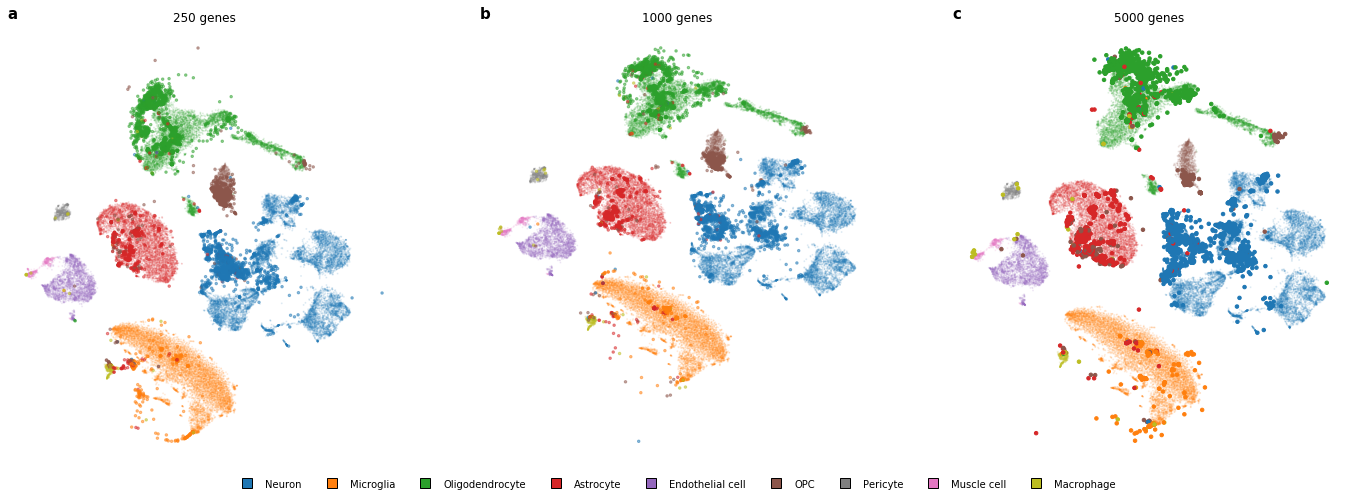

In [44]:
fig, ax = plt.subplots(ncols=3, figsize=(24, 8))

utils.plot(adata_3000.obsm["tsne"], adata.obs["labels"], s=1, colors=colors, draw_legend=False, ax=ax[0], alpha=0.1, title="250 genes", label_order=list(colors.keys()))
utils.plot(new_250.obsm["tsne"], new.obs["labels"], s=6, colors=colors, draw_legend=False, ax=ax[0], alpha=0.5, label_order=list(colors.keys()))

utils.plot(adata_3000.obsm["tsne"], adata.obs["labels"], s=1, colors=colors, draw_legend=True, ax=ax[1], alpha=0.1, title="1000 genes", label_order=list(colors.keys()),
          legend_kwargs=legend_kwargs)
utils.plot(new_1000.obsm["tsne"], new.obs["labels"], s=6, colors=colors, draw_legend=False, ax=ax[1], alpha=0.5, label_order=list(colors.keys()))

utils.plot(adata_3000.obsm["tsne"], adata.obs["labels"], s=1, colors=colors, draw_legend=False, ax=ax[2], alpha=0.1, title="5000 genes", label_order=list(colors.keys()))
utils.plot(new_5000.obsm["tsne"], new.obs["labels"], s=12, colors=colors, draw_legend=False, ax=ax[2], alpha=1, label_order=list(colors.keys()))

plt.text(0, 1.02, "a", transform=ax[0].transAxes, fontsize=15, fontweight="bold")
plt.text(0, 1.02, "b", transform=ax[1].transAxes, fontsize=15, fontweight="bold")
plt.text(0, 1.02, "c", transform=ax[2].transAxes, fontsize=15, fontweight="bold")

plt.savefig("hrvatin_transform_tsne_genes.png", dpi=100, bbox_inches="tight", transparent=True)
plt.savefig("hrvatin_transform_tsne_genes.pdf", dpi=600, bbox_inches="tight", transparent=True)

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 16))

utils.plot(adata_3000.obsm["tsne"], adata.obs["labels"], s=3, colors=colors, draw_legend=False, ax=ax[0, 0], alpha=0.1, title="Initialization", label_order=list(colors.keys()))
utils.plot(new_250.obsm["tsne_init"], new.obs["labels"], s=12, colors=colors, draw_legend=False, ax=ax[0, 0], alpha=1, label_order=list(colors.keys()))

utils.plot(adata_3000.obsm["tsne"], adata.obs["labels"], s=3, colors=colors, draw_legend=False, ax=ax[0, 1], alpha=0.1, title="250 genes", label_order=list(colors.keys()))
utils.plot(new_250.obsm["tsne"], new.obs["labels"], s=12, colors=colors, draw_legend=False, ax=ax[0, 1], alpha=1, label_order=list(colors.keys()))

utils.plot(adata_3000.obsm["tsne"], adata.obs["labels"], s=3, colors=colors, draw_legend=False, ax=ax[1, 0], alpha=0.1, title="1000 genes", label_order=list(colors.keys()))
utils.plot(new_1000.obsm["tsne"], new.obs["labels"], s=12, colors=colors, draw_legend=False, ax=ax[1, 0], alpha=1, label_order=list(colors.keys()))

utils.plot(adata_3000.obsm["tsne"], adata.obs["labels"], s=3, colors=colors, draw_legend=True, ax=ax[1, 1], alpha=0.1, title="17078 genes", label_order=list(colors.keys()),
          legend_kwargs=dict(bbox_transform=fig.transFigure, loc="lower center", bbox_to_anchor=(0.5, 0.075), ncol=len(np.unique(adata.obs["labels"]))))
utils.plot(new_full.obsm["tsne"], new.obs["labels"], s=12, colors=colors, draw_legend=False, ax=ax[1, 1], alpha=1, label_order=list(colors.keys()))

#fig.tight_layout()

fig.text(0, 1.02, "a", transform=ax[0, 0].transAxes, fontsize=15, fontweight="bold")
fig.text(0, 1.02, "b", transform=ax[0, 1].transAxes, fontsize=15, fontweight="bold")
fig.text(0, 1.02, "c", transform=ax[1, 0].transAxes, fontsize=15, fontweight="bold")
fig.text(0, 1.02, "d", transform=ax[1, 1].transAxes, fontsize=15, fontweight="bold")